In [94]:
import re
import os
import csv
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from functools import reduce
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Tahoma'

# Import data and convert it into 1 dataframe

In [48]:
def get_data(path):
    dir_path = path
    for filename in os.listdir(dir_path):
        if filename.endswith('.csv'):
            with open(os.path.join(dir_path, filename)) as csvfile:
                data = list(csv.reader(csvfile))
            yield data

def create_dataframe(data):
    for d in data:
        try:
            df = pd.DataFrame(d[1:], columns=d[0])
            yield df
        except Exception as e:
            print(f"Error creating DataFrame: {e}")

data = get_data('data/')
df_list = list(create_dataframe(data))
df = reduce(lambda df1,df2: pd.merge(df1,df2,how ='outer'), df_list)
df = df.iloc[:, 5:]

In [49]:
def clean_space(df, columns: dict):
    df_copy = df.copy()
    for column in columns:
            df_copy[column] = df_copy[column].astype(str)
            df_copy[column] = df_copy[column].str.replace('\n', '').str.strip()
            df_copy[column] = df_copy[column].apply(lambda x: re.sub(r'\s{2,}', columns[column], x))
            yield column, df_copy[column]

def replace_column_data(df, columns_data: dict):
    df_replaced = df.copy()
    for key in columns_data.keys():
        df_replaced[key] = columns_data[key]
    return df_replaced

clean_columns = dict(clean_space(df, {"facility": ',', "space": ' '}))
df = replace_column_data(df, clean_columns)

# Clean data

## clean empty data to NaN and change type of data to its correct type

In [50]:
df = df.replace(["null", "ไม่มีข้อมูล"], np.NaN)
df["price"] = df["price"].replace(r",", '', regex = True).astype(float)
df["bedroom"] = df["bedroom"].replace("สตูดิโอ", 0).astype(float)
df["bathroom"] = df["bathroom"].astype(float)
df["space"] = df["space"].str.extract(r"([\d\.]+[\d+])").astype(float)
df["year"] = df["year"].str.extract(r"(\d{4})").astype(float)
df["floor"] = df["floor"].astype(float)
df.rename(columns={"area (keat)": "area", "Province": "province"}, inplace=True)

## extract number distance from station and convert to float

In [51]:
def station(df):
    for i in range(len(df)):
        if isinstance(df['station'][i], float) and np.isnan(df['station'][i]):
            yield np.NaN, np.NaN, np.NaN
        else:
            match = re.search(r'สถานีใกล้เคียง\d+ นาที \((\d+) ม.\) ถึง (\w+)\s(\w+)\s[ก-๙]+', str(df['station'][i]))
            yield match.groups() if match else np.nan

test_df = pd.DataFrame(station(df))
test_df.columns = ['distance','station_id','station_type']
test_df["distance"] = test_df["distance"].astype(float)
df = pd.merge(df, test_df, left_index=True, right_index=True, how="left")
df = df.drop(columns="station")

In [52]:
df.loc[1, "facility"]

'สิ่งอำนวยความสะดวก & สถานที่ใกล้เคียง,สิ่งอำนวยความสะดวก,ลานจอดรถ,กล้องวงจรปิด,ห้องเล่นเกมส์,ห้องสมุด,สนามเด็กเล่น,ซาวน่า,รักษาความปลอดภัย 24 ชม.,สปา สระว่ายน้ำ,สนามสควอช,สระว่ายน้ำ,สนามเทนนิส'

## seperate each function of facility into their own category

In [53]:
def separate_facilities(df, **kwargs):
    for col_name, keywords in kwargs.items():
        df[col_name] = df["facility"].apply(lambda x: True if isinstance(x, str) and any(keyword in x for keyword in keywords) else False)
    return df

df = separate_facilities(df, 
                            is_Security = ['รักษาความปลอดภัย 24 ชม.','ระบบรักษาความาปลอดภัยการเข้า-ออกอาคาร'],
                            is_Laundry =['ซัก อบ รีด', 'เครื่องซักผ้า'],
                            is_Parking_Lot= ['ที่จอดรถ','ลานจอดรถ','ลานจอดรถใต้ดิน','โรงรถ'],
                            is_Bus_Stop= ['ป้ายรถเมล์'],
                            is_Cleaning=['พนักงานทำความสะอาด'],
                            is_Fitness =['ฟิตเนส','ลู่วิ่ง',],
                            is_Convenient_Store = ['มินิมาร์ท',],
                            is_Balcony=['ระเบียง',],
                            is_View = ['วิวทะเล','วิวสระว่ายน้ำ','วิวเมือง','สวน/วิวสวนธรรมชาติ'],
                            is_Sport_Facility = ['สนามบาส','สนามสควอช','สนามหัดเล่นกอล์ฟ','สนามเด็กเล่น','สนามเทนนิส','สนามแบดมินตัน','ห้องบิลเลียด','ห้องยิมนาสติก'],
                            is_Pool =['สปา สระว่ายน้ำ','สระว่ายน้ำ','สระว่ายน้ำส่วนตัว','สระว่ายน้ำเพื่อความสนุก','สระเด็ก',],
                            is_Park= ['สวนสาธารณะ',],
                            is_Garden = ['สวนส่วนตัว',],
                            is_corner_room = ['ห้องมุม',])

df = df.drop(columns="facility")

| Column Name   | Explanation                                     |
| ------------- | -------------------------------------------------|
| name          | Name of the property or listing                 |
| price         | Price of the property or listing                |
| province      | Province where the property is located          |
| area  | Area of the property in "keat" units            |
| district      | District where the property is located          |
| bedroom       | Number of bedrooms in the property             |
| bathroom      | Number of bathrooms in the property            |
| space         | Space or size of the property                  |
| year          | Year of construction or listing                |
| type          | Type of property (e.g., house, apartment, etc.)|
| furniture     | Information about the furniture in the property|
| floor         | Floor number or level of the property          |
| distance (m.) | Distance to a certain point (e.g., a station) in meters|
| station_type  | Type of nearby station (e.g., MRT, BTS, etc.)    |
| station_name  | Name of the nearby station                      |

# Delete Column 
ลบ column ที่ซ้ำซ้อน

In [54]:
df = df.drop(['province', 'station_type', 'area'], axis = 1)

In [55]:
df.head(3)

,name,price,district,bedroom,bathroom,space,year,type,furniture,floor,distance,station_id,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room
0,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ",17500000.0,บางคอแหลม,3.0,3.0,240.0,2006.0,ขายขาด,NaN,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False
1,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ",19000000.0,บางคอแหลม,3.0,3.0,230.0,2006.0,ขายขาด,NaN,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False
2,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,2500000.0,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,NaN,150.0,B10,True,False,True,False,False,False,False,False,False,True,True,False,False,False


## Clean name column

In [56]:
df["name"] = df["name"].str.extract(r"(?P<name>.+)[,]")
df["name"] = df["name"].str.extract(r"(?P<name>.+?[:]|.+)")
df["name"] = df["name"].str.replace(":", "").str.strip()

## Box plot to check value outliner

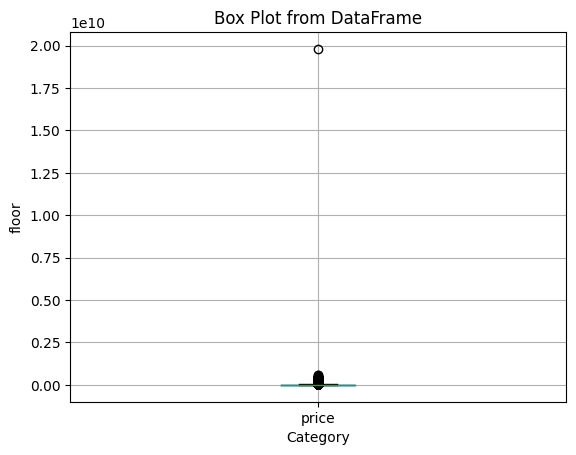

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

df.boxplot(column=["price"])

# Add labels and title
plt.xlabel('Category')
plt.ylabel('floor')
plt.title('Box Plot from DataFrame')

plt.show()

In [58]:
df[df['price'] == df['price'].max()]

,name,price,district,bedroom,bathroom,space,year,type,furniture,floor,distance,station_id,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room
7076,The Pano Rama 3,1.980000e+10,บางโพงพาง,2.0,2.0,137.0,2010.0,ขายขาด,ตกแต่งครบ,34.0,400.0,B6,True,True,True,False,False,True,False,True,False,True,True,True,False,False


## clean wrong ourliner

In [59]:
df.loc[4564, "floor"] = 15 #ตึกไม่สูงพอ
df.loc[2662, "space"] = 605 #ตึกไม่กว้างพอ (เทียบกับห้องอื่นโครงเดียวกัน)
df.loc[7076, "price"] = 19_800_000 #แพงไปไม่มีใครซื้อ

In [60]:
combined_list = sum(df["name"].astype(str).str.split(',') , [])
set(combined_list)

{' 35 ตรม. 1 นอน ห้องสวย สภาพดีมาก',
 ' 4 ห้องนอน',
 ' BTS',
 ' Bangkok near BRT Sathorn at Liang Garden',
 ' Bangkok near BTS Chong',
 ' Bangkok near BTS Chong Nonsi',
 ' Bangkok near BTS Ratchadamri',
 ' กรุงเทพ',
 ' ธนบุรี',
 ' สำเหร่',
 '-',
 '1 bedroom condo at Siamese Surawong for sale or rent',
 '1 bedroom condo at Urbana Sathorn for rent and sale',
 '1 bedroom condo for rent and sale at The Rajadamri',
 '1 bedroom condo for sale and for rent at Socio Ruamrudee',
 '1 bedroom condo for sale with tenant at Saladaeng One',
 '1 bedroom condo for sale with tenant at The River',
 '125 SATHORN',
 '185 Rajadamri',
 '185 ราชดำริ',
 '2 bedroom condo at Athenee Residence for sale',
 '2 bedroom condo for for sale at Saladaeng Residences',
 '2 bedroom condo for rent and sale at Langsuan Ville',
 '2 bedroom condo for sale and rent at The River',
 '2 bedroom condo for sale at Baan Sathorn Chaophraya',
 '2 bedroom condo for sale at Q Langsuan',
 '2+1 bedroom property for rent and sale at The Ri

# Clean district column



In [61]:
district_name = {'The Met Sathorn' : 'ทุ่งมหาเมฆ',
 'ASHTON Silom : แอชตัน สีลม' : 'สุริยวงศ์',
 'Nara 9 สาทร-นราธิวาส': 'ทุ่งมหาเมฆ',
 'StarView Rama 3' : 'บางโคล่',
 'Villa Sathorn':'คลองต้นไทร',
 'The Park Chidlom' : 'ลุมพินี',
 r'M สีลม \(เอ็ม สีลม\)' : 'สุริยวงศ์',
 'Supalai Premier Ratchada-Narathiwas-Sathorn : ศุภาลัย พรีเมียร์ รัชดาฯ-นราธิวาส-สาทร' : 'ช่องนนทรี',
 r'Baan Nonsi \(บ้านนนทรี\)' : 'ช่องนนทรี',
 r'CU Terrace \(ระเบียงจามจุรี\)' : 'วังใหม่',
 'ปทุมวัน โอเอซิส คอนโดมิเนียม' : 'วังใหม่',
 'สุพรีม คลาสิค คอนโดมิเนียม' : 'ทุ่งมหาเมฆ'
 }
for key in district_name:
    df.loc[df['district'].str.contains(key), 'district'] = district_name[key]

df['district'].value_counts()

ลุมพินี            1584
ทุ่งมหาเมฆ          788
คลองต้นไทร          744
สีลม                708
ช่องนนทรี           584
บางโพงพาง           391
ยานนาวา             309
ดาวคะนอง            275
บางลำภูล่าง         256
ทุ่งวัดดอน          249
สี่พระยา            248
มหาพฤฒาราม          207
บุคคโล              185
บางโคล่             182
วัดพระยาไกร         155
ตลาดพลู             143
สุริยวงศ์           115
วังใหม่              94
บางคอแหลม            78
คลองสาน              62
สำเหร่               49
รองเมือง             38
สมเด็จเจ้าพระยา      10
ปทุมวัน               9
บางยี่เรือ            7
หิรัญรูจี             6
บางรัก                1
Name: district, dtype: int64

# EDA

In [62]:
### 


# LabelEncoder ( เป็น order )

`ตกแต่งครบ    2
มีบางส่วน     1
ไม่มี         0`

In [63]:
df['furniture'].unique()

array([nan, 'ตกแต่งครบ', 'มีบางส่วน', 'ไม่มี'], dtype=object)

In [64]:
import pandas as pd

furniture = {'ตกแต่งครบ' : 2, 'มีบางส่วน' : 1, 'ไม่มี' : 0}

df['furniture_encoded'] = df['furniture'].map(furniture)
df = df.drop('furniture', axis =1 )
df.head(5)


,name,price,district,bedroom,bathroom,space,year,type,floor,distance,station_id,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room,furniture_encoded
0,Supalai Casa Riva,17500000.0,บางคอแหลม,3.0,3.0,240.0,2006.0,ขายขาด,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN
1,Supalai Casa Riva,19000000.0,บางคอแหลม,3.0,3.0,230.0,2006.0,ขายขาด,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN
2,Lumpini Place Rama 3 - Riverview,2500000.0,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,150.0,B10,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN
3,Lumpini Place Rama 3 - Riverview,3100000.0,บางโคล่,1.0,1.0,40.0,2004.0,NaN,NaN,150.0,B10,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN
4,Lumpini Place Rama 3 - Riverview,28500000.0,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,150.0,B10,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN


# Change categorical column to one-hot encoding

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7477 entries, 0 to 7476
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 7468 non-null   object 
 1   price                7469 non-null   float64
 2   district             7477 non-null   object 
 3   bedroom              7424 non-null   float64
 4   bathroom             7401 non-null   float64
 5   space                7474 non-null   float64
 6   year                 6669 non-null   float64
 7   type                 6675 non-null   object 
 8   floor                4211 non-null   float64
 9   distance             6613 non-null   float64
 10  station_id           6613 non-null   object 
 11  is_Security          7477 non-null   bool   
 12  is_Laundry           7477 non-null   bool   
 13  is_Parking_Lot       7477 non-null   bool   
 14  is_Bus_Stop          7477 non-null   bool   
 15  is_Cleaning          7477 non-null   b

In [66]:
from sklearn.preprocessing import OneHotEncoder

In [67]:
df1 = df.copy()

In [68]:
category_column = ['type','station_id']

In [69]:
# df_dummy = pd.get_dummies(df['area'], prefix='เขต',prefix_sep='', drop_first=True)
# df = pd.merge(df, df_dummy, left_index=True, right_index=True , how = "inner")
# df = df.drop('area', axis = 1)

In [70]:
df_dummy = pd.get_dummies(df['district'], prefix='แขวง',prefix_sep='' ,drop_first=True)
df = pd.merge(df, df_dummy, left_index=True, right_index=True , how = "inner")
df = df.drop('district', axis = 1)

In [71]:
for col in category_column:
    df_dummy = pd.get_dummies(df[col], drop_first=True)
    df = pd.merge(df, df_dummy, left_index=True, right_index=True , how = "inner")
    df = df.drop(col, axis = 1)

In [72]:
df.head()

,name,price,bedroom,bathroom,space,year,floor,distance,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room,furniture_encoded,แขวงคลองสาน,แขวงช่องนนทรี,แขวงดาวคะนอง,แขวงตลาดพลู,แขวงทุ่งมหาเมฆ,แขวงทุ่งวัดดอน,แขวงบางคอแหลม,แขวงบางยี่เรือ,แขวงบางรัก,แขวงบางลำภูล่าง,แขวงบางโคล่,แขวงบางโพงพาง,แขวงบุคคโล,แขวงปทุมวัน,แขวงมหาพฤฒาราม,แขวงยานนาวา,แขวงรองเมือง,แขวงลุมพินี,แขวงวังใหม่,แขวงวัดพระยาไกร,แขวงสมเด็จเจ้าพระยา,แขวงสำเหร่,แขวงสีลม,แขวงสี่พระยา,แขวงสุริยวงศ์,แขวงหิรัญรูจี,เช่าซื้อระยะยาว 30 ปี,เช่าระยะยาว,B10,B11,B12,B2,B3,B4,B5,B6,B7,B8,B9,BL24,BL25,BL26,BL27,BL28,BL30,E1,E14,E2,E3,G2,G3,PP03,RN07,S1,S10,S11,S2,S3,S4,S5,S6,S7,S8,S9,W1
0,Supalai Casa Riva,17500000.0,3.0,3.0,240.0,2006.0,NaN,720.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Supalai Casa Riva,19000000.0,3.0,3.0,230.0,2006.0,NaN,720.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Lumpini Place Rama 3 - Riverview,2500000.0,1.0,1.0,39.0,2004.0,NaN,150.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Lumpini Place Rama 3 - Riverview,3100000.0,1.0,1.0,40.0,2004.0,NaN,150.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Lumpini Place Rama 3 - Riverview,28500000.0,1.0,1.0,39.0,2004.0,NaN,150.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [73]:
df.shape


(7477, 88)

# Model

In [74]:
df['price'].dropna(inplace=True)

In [75]:
df.dropna(subset=['price'], inplace=True)


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7469 entries, 0 to 7476
Data columns (total 88 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   7460 non-null   object 
 1   price                  7469 non-null   float64
 2   bedroom                7419 non-null   float64
 3   bathroom               7396 non-null   float64
 4   space                  7468 non-null   float64
 5   year                   6662 non-null   float64
 6   floor                  4206 non-null   float64
 7   distance               6606 non-null   float64
 8   is_Security            7469 non-null   bool   
 9   is_Laundry             7469 non-null   bool   
 10  is_Parking_Lot         7469 non-null   bool   
 11  is_Bus_Stop            7469 non-null   bool   
 12  is_Cleaning            7469 non-null   bool   
 13  is_Fitness             7469 non-null   bool   
 14  is_Convenient_Store    7469 non-null   bool   
 15  is_B

In [87]:
df.shape


(7469, 88)

---
## Split data 
split data to train and test

In [77]:
from sklearn.model_selection import train_test_split

In [88]:
X = df.drop(columns = ['price', 'name'])
y = df['price']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

---
## Instantiate the different regression models

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

from math import sqrt
from statistics import mode

In [81]:
def display_model_score(model):

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print("-"*50)
    print(model.__class__.__name__)
    print("-"*50)
    print(f"Coefficient of Determination")
    print(f"train score : {model.score(X_train, y_train)}")
    print(f"test  score : {model.score(X_test, y_test)}")
    print("-"*50)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", sqrt(mse))
    print("-"*50)

In [99]:
def display_important_feature(models):
    importances = models.feature_importances_
    indices = np.argsort(importances)
    features = X.columns
    plt.figure(figsize=(15, 15))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='r', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

# Decision Tree 

### Random Forest - Regression

# XGBoots

In [ ]:
# param_grid = {'learning_rate': [i/10 for i in range(1,10)],
#             'max_depth': list(range(2,15)),
#             'n_estimators' : list(range(10,100,10))} 

# xgb = XGBRegressor()

# grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# xgb_learning_rate = grid_search.best_params_['learning_rate']
# xgb_max_depth = grid_search.best_params_['max_depth']
# xgb_n_estimators = grid_search.best_params_['n_estimators']
 
# print('Best Hyperparameters:', grid_search.best_params_)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

--------------------------------------------------
XGBRegressor
--------------------------------------------------
Coefficient of Determination
train score : 0.9972417364954999
test  score : 0.9183137092515796
--------------------------------------------------
Mean Squared Error: 93480324064109.5
Root Mean Squared Error: 9668522.330951586
--------------------------------------------------


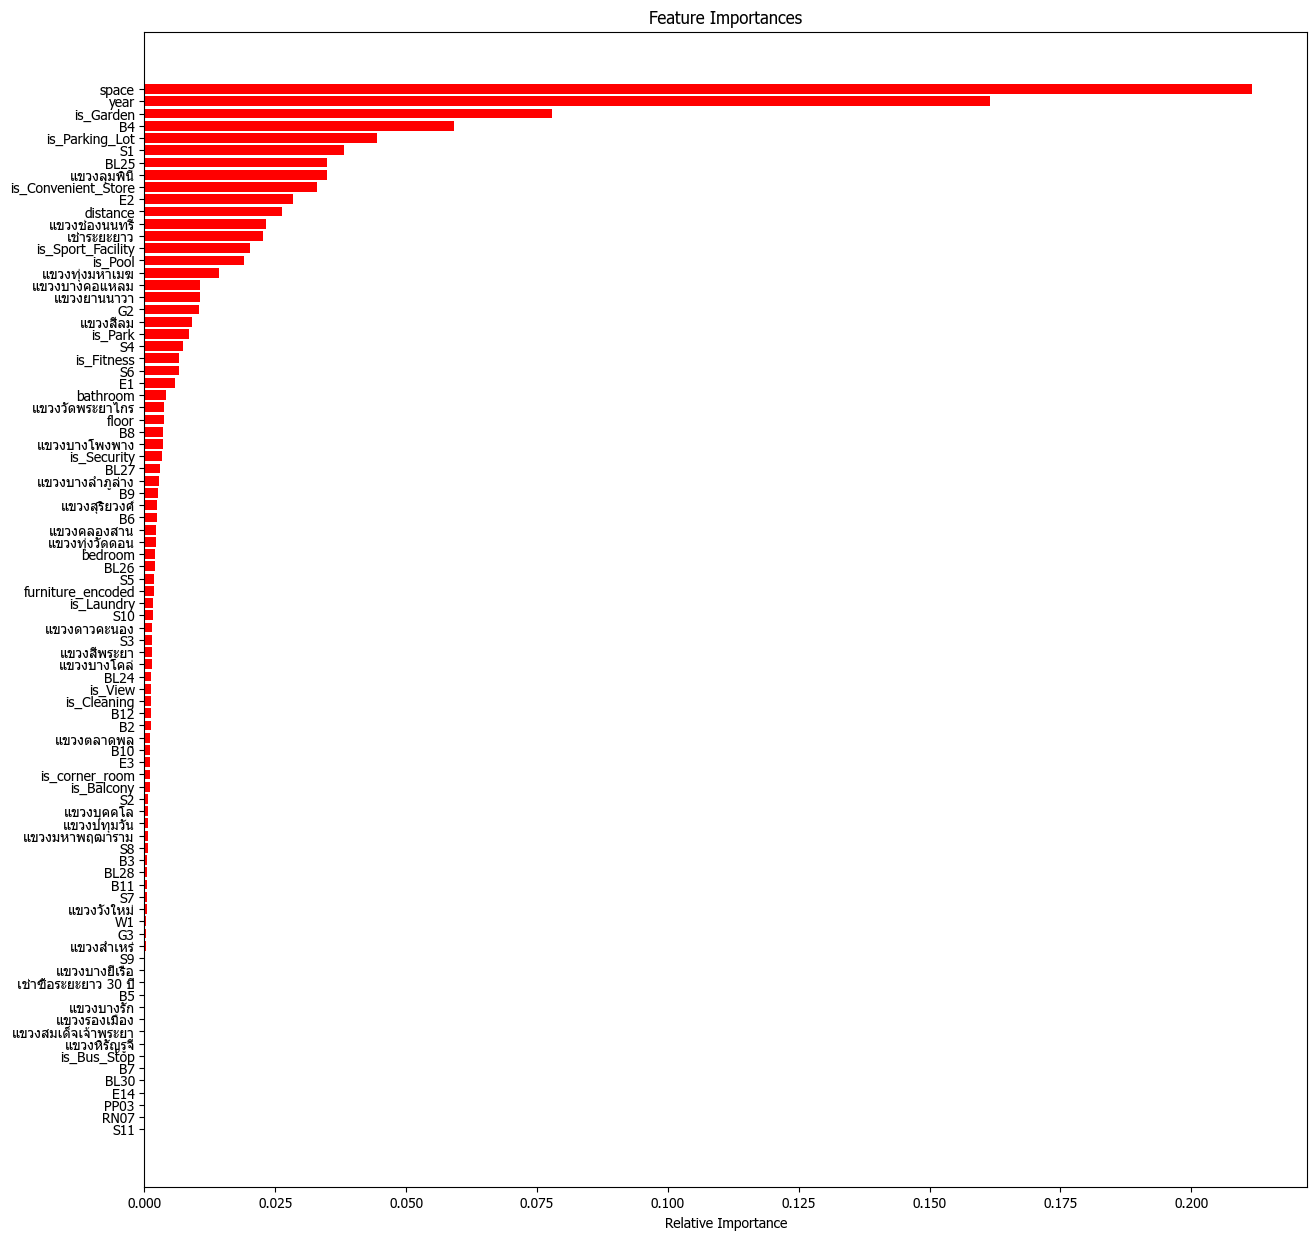

In [100]:
# xgb = XGBRegressor(learning_rate=xgb_learning_rate, max_depth=xgb_max_depth, n_estimators=xgb_n_estimators)
# xgb = XGBRegressor()
xgb = XGBRegressor(learning_rate=0.1, max_depth=10, n_estimators=100)
xgb.fit(X_train, y_train)

display_model_score(xgb)
display_important_feature(xgb)

In [134]:
# import lightgbm as lgb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import accuracy_score,r2_score

# lgbm = lgb.LGBMRegressor()
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': 'mse',
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0,
#     'force_row_wise': True
# }

# fit_params={'early_stopping_rounds':100, 
#             'eval_set': [(X_test, y_test)],
#             'verbose': 5
#            }



# lgbm.fit(X_train, y_train)
# lgbm.fit(X_train, y_train, **fit_params)

# display_model_score(lgbm)
# display_important_feature(lgbm)


[5]	valid_0's l2: 4.95365e+14
[10]	valid_0's l2: 2.87426e+14
[15]	valid_0's l2: 2.14247e+14
[20]	valid_0's l2: 1.9031e+14
[25]	valid_0's l2: 1.75953e+14
[30]	valid_0's l2: 1.68095e+14
[35]	valid_0's l2: 1.6111e+14
[40]	valid_0's l2: 1.5114e+14
[45]	valid_0's l2: 1.46401e+14
[50]	valid_0's l2: 1.43545e+14
[55]	valid_0's l2: 1.39093e+14
[60]	valid_0's l2: 1.36607e+14
[65]	valid_0's l2: 1.34788e+14
[70]	valid_0's l2: 1.33751e+14
[75]	valid_0's l2: 1.3315e+14
[80]	valid_0's l2: 1.31167e+14
[85]	valid_0's l2: 1.29811e+14
[90]	valid_0's l2: 1.2765e+14
[95]	valid_0's l2: 1.27453e+14
[100]	valid_0's l2: 1.25747e+14


c:\Users\User\miniconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\User\miniconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMRegressor()

In [117]:
import numpy as np

# obtain predictions on test set
y_pred = lgbm.predict(X_test)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)


RMSE: 10479539.508570882


In [119]:
y =lgbm.predict(X_train)
y_pred = lgbm.predict(X_test)
train_r2 = r2_score(y_train, y)
test_r2 = r2_score(y_test, y_pred)
print("R-squared train:", train_r2)
print("R-squared test:", test_r2)

R-squared train: 0.9828816135798105
R-squared test: 0.9040348900518768


In [124]:
halo = lgb.LGBMRegressor()
halo.fit(X_train, y_train)

halo.score(X_train, y_train)
halo.score(X_test, y_test)

0.8901184243853594

---
## Train and evaluate each model using cross-validation

In [ ]:
# from sklearn.model_selection import cross_val_score, KFold

In [ ]:
# kf = KFold(n_splits=5, shuffle=True, random_state = 42)

# model_list = [dt, rf, xgb]

# result = {}

# for model in model_list:
#     cv_scores = cross_val_score(model,X,y,cv=kf)
#     result[model.__class__.__name__] = np.mean(cv_scores)

# result